In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import sys
import shutil

import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection, multipletests
from itertools import combinations

import matplotlib.pyplot as plt

from scipy.stats import pearsonr
import seaborn as sns
from random import sample, seed


from unipressed import IdMappingClient
import time

### Results

In [2]:
data_folder = "snakemake/only_pc_results/"

In [3]:
df = pd.read_csv(data_folder + "exp_results/protein_models.tsv", sep='\t')
df

coef_id      coef  std err          z          P>|z|    [0.025  \
0       Intercept -3.015108    1.408  -2.141805   3.259630e-02 -5.779601   
1          Pdhbai  0.230681    0.124   1.867180   6.234590e-02 -0.011934   
2       Intercept -0.466585    0.122  -3.824890   1.440006e-04 -0.706140   
3          QjgJPf  0.013504    0.017   0.777253   4.373045e-01 -0.020615   
4       Intercept -0.473423    0.080  -5.899698   5.977890e-09 -0.631007   
...           ...       ...      ...        ...            ...       ...   
330517     QiIVHe -0.013665    0.023  -0.604609   5.456571e-01 -0.058049   
330518  Intercept  1.868605    0.048  39.071104  2.901457e-170  1.774688   
330519     QigSZc -0.030928    0.014  -2.139476   3.278196e-02 -0.059316   
330520  Intercept  1.896367    0.058  32.453820  2.063866e-136  1.781619   
330521     QfTAef -0.022078    0.012  -1.805494   7.147621e-02 -0.046091   

          0.975]  converged  pseudo_r2  train_MSE       MSE  train_pearsonR  \
0      -0.250615        625   0.005565   3.210609  3.513522        0.074599   
1       0.473297        625   0.005565   3.210609  3.513522        0.074599   
2      -0.227031        625   0.000969   3.225448  3.515178        0.031125   
3       0.047624        625   0.000969   3.225448  3.515178        0.031125   
4      -0.315839        625   0.008508   3.201106  3.497765        0.092240   
...          ...        ...        ...        ...       ...             ...   
330517  0.030719        630   0.000582   1.194978  1.039028        0.024120   
330518  1.962523        630   0.007236   1.187021  1.008061        0.085065   
330519 -0.002540        630   0.007236   1.187021  1.008061        0.085065   
330520  2.011114        630   0.005164   1.189499  1.001558        0.071861   
330521  0.001935        630   0.005164   1.189499  1.001558        0.071861   

        pearsonR          drug  n_train  n_test protein  
0       0.020938  CHEMBL109480      625     156  P37108  
1       0.020938  CHEMBL109480      625     156  P37108  
2      -0.024041  CHEMBL109480      625     156  Q96JP5  
3      -0.024041  CHEMBL109480      625     156  Q96JP5  
4       0.047680  CHEMBL109480      625     156  Q9Y4H2  
...          ...           ...      ...     ...     ...  
330517 -0.034130      CHEMBL98      630     156  Q8IVH4  
330518  0.185834      CHEMBL98      630     156  Q86SZ2  
330519  0.185834      CHEMBL98      630     156  Q86SZ2  
330520  0.250521      CHEMBL98      630     156  Q5TA45  
330521  0.250521      CHEMBL98      630     156  Q5TA45  

[330522 rows x 17 columns]

In [4]:
df_prot = df[df.coef_id != 'Intercept'].copy()
# df_prot.protein = df_prot.protein.str.replace('-7','Z').str.split('.', expand=True)[1].str.split('_', expand=True)[0]

In [5]:
uni_to_prot = pd.read_csv('snakemake/data/uniprot_protein.csv').set_index('UniProt')

In [6]:
df_prot.protein = uni_to_prot.loc[df_prot.protein].values

In [7]:
df_prot.sort_values('pearsonR')

coef_id      coef  std err         z     P>|z|    [0.025    0.975]  \
271433  Pbdgbb -0.005400    0.012 -0.466395  0.641095 -0.028135  0.017336   
37533   QiNCee -0.034655    0.034 -1.019346  0.308431 -0.101416  0.032107   
272417  Pbgadf -0.058302    0.041 -1.419241  0.156325 -0.138972  0.022368   
296439  Pedaah -0.011263    0.027 -0.419605  0.674919 -0.063975  0.041449   
98231   QjgKcb  0.007768    0.021  0.369139  0.712149 -0.033556  0.049092   
...        ...       ...      ...       ...       ...       ...       ...   
330027  Qbggfa -0.186833    0.084 -2.234869  0.025777 -0.351001 -0.022665   
330221  QjUKjj  0.000000    0.000       NaN       NaN  0.000000  0.000000   
330295  QjUKVi -0.079186    0.056 -1.406396  0.160101 -0.189754  0.031381   
330371  Oedjcj -0.128537    0.073 -1.765747  0.077924 -0.271487  0.014413   
330471  Obejhc -0.154072    0.109 -1.413821  0.157910 -0.368072  0.059929   

        converged  pseudo_r2  train_MSE       MSE  train_pearsonR  pearsonR  \
271433        630   0.000346   0.865644  0.734126        0.018608 -0.324055   
37533         630   0.001652   4.513678  5.497544        0.040643 -0.314091   
272417        630   0.003197   0.863175  0.762908        0.056543 -0.313656   
296439        624   0.000283   8.754002  8.091747        0.016822 -0.312814   
98231         630   0.000217   2.557243  3.143441        0.014729 -0.305935   
...           ...        ...        ...       ...             ...       ...   
330027        630   0.007890   1.186239  1.035498        0.088828       NaN   
330221        630   0.000000   1.195673  1.035496             NaN       NaN   
330295        630   0.003140   1.191919  1.035497        0.056033       NaN   
330371        630   0.004940   1.189767  1.035510        0.070287       NaN   
330471        630   0.003173   1.191880  1.035486        0.056328       NaN   

                 drug  n_train  n_test protein  
271433    CHEMBL64925      630     155   CSPG2  
37533   CHEMBL1231160      630     156   RETR2  
272417    CHEMBL64925      630     155   TIMP2  
296439      CHEMBL888      624     154    SATT  
98231    CHEMBL191334      630     156   ANCHR  
...               ...      ...     ...     ...  
330027       CHEMBL98      630     156    TBR1  
330221       CHEMBL98      630     156    FBX3  
330295       CHEMBL98      630     156    AGO2  
330371       CHEMBL98      630     156    ORC4  
330471       CHEMBL98      630     156   VP26C  

[165261 rows x 17 columns]

In [43]:
df_prot[(df_prot.protein == 'FA83B') & (df_prot.drug == 'CHEMBL554')]

coef_id      coef  std err        z         P>|z|    [0.025    0.975]  \
242693  QfTaWj -0.151028    0.019 -7.77367  3.136796e-14 -0.189181 -0.112876   

        converged  pseudo_r2  train_MSE       MSE  train_pearsonR  pearsonR  \
242693        629   0.087907   2.835257  2.502968        0.296491  0.254853   

             drug  n_train  n_test protein   p_corrected  
242693  CHEMBL554      629     155   FA83B  2.771360e-11

In [9]:
protein_list = df_prot.protein.unique()
protein_list

array(['SRP14', 'ZFP91', 'IRS2', ..., 'MMAA', 'TPC6B', 'INT11'],
      dtype=object)

#### visual diff coef

<Axes: >

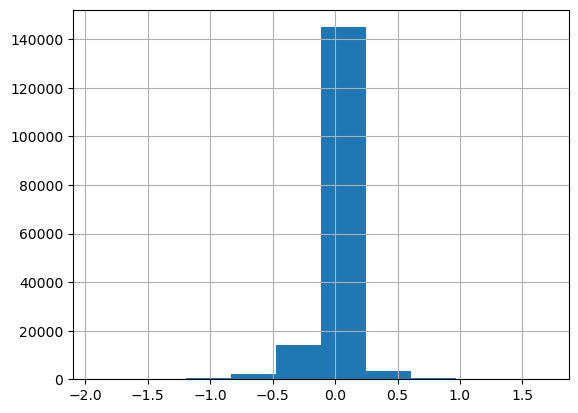

In [8]:
df_prot.coef.hist()

In [9]:
high_std = df_prot.groupby('protein').agg({'coef':['mean','std', 'min', 'max']}).sort_values([('coef', 'std')]).tail(10).index.to_list()
df_prot.groupby('protein').agg({'coef':['mean','std', 'min', 'max']}).sort_values([('coef', 'std')])

coef                              
             mean       std       min       max
protein                                        
WDFY4    0.000000  0.000000  0.000000  0.000000
PLEK     0.000000  0.000000  0.000000  0.000000
FBX3     0.000000  0.000000  0.000000  0.000000
ITA2B    0.000000  0.000000  0.000000  0.000000
ACAP1    0.000000  0.000000  0.000000  0.000000
...           ...       ...       ...       ...
SRRT    -0.338978  0.578077 -1.270092  0.782204
SRSF3   -0.349627  0.601415 -1.176346  0.952994
SMD2    -0.636523  0.637957 -1.782506  0.546539
HNRPK   -0.514050  0.643553 -1.637379  0.822270
TADBP   -0.408088  0.722205 -1.419230  1.692443

[5331 rows x 4 columns]

In [10]:
mask = [p in high_std for p in df_prot.protein]

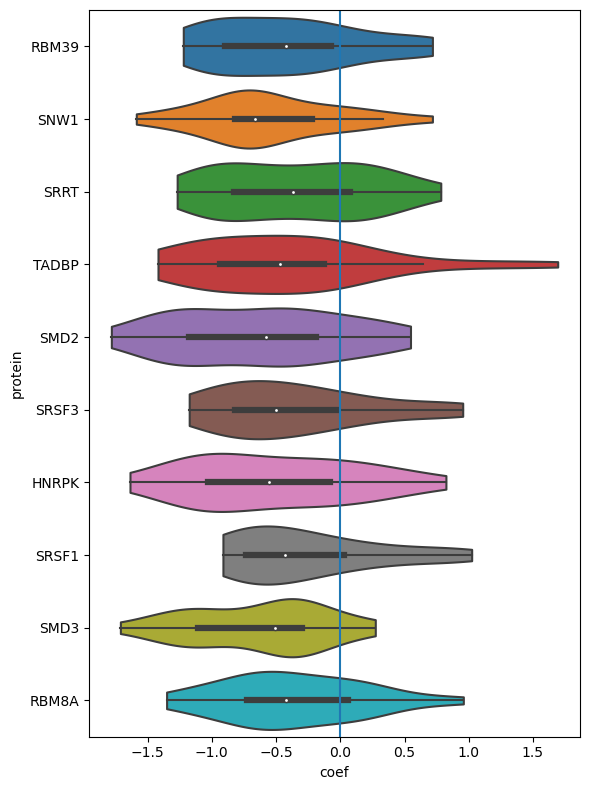

In [11]:
plt.rcParams['figure.figsize'] = (6,8)
plt.rcParams['figure.autolayout'] = True
sns.violinplot(df_prot[mask], x='coef', y='protein', cut=0, scale="count")
plt.axvline(0, 0)
plt.show()

#### back to regression

In [10]:
protein_list.shape

(5331,)

In [11]:
df_prot = df_prot.dropna()

In [12]:
alpha = 0.05
filter = 0.5

sig_proteins = []

drug_list = df_prot.drug.unique()

df_prot['p_corrected'] = 10.0

for d in drug_list:
    df_prot.loc[df_prot.drug == d, 'p_corrected'] = multipletests(df_prot['P>|z|'][df_prot.drug == d], method='fdr_bh', alpha=alpha)[1]
    

In [13]:
sig_proteins = df_prot[df_prot.p_corrected < alpha].copy()


In [14]:
df_prot[df_prot.p_corrected < alpha]

coef_id      coef  std err         z         P>|z|    [0.025    0.975]  \
11      Ohgadb -0.459310    0.153 -3.006429  2.749772e-03 -0.759328 -0.159292   
15      AgNIHh  0.058805    0.020  2.904821  3.804936e-03  0.019050  0.098559   
23      QgiDKh  0.113692    0.028  3.994716  7.251017e-05  0.057802  0.169582   
41      QjUNFb  0.062207    0.017  3.717237  2.195502e-04  0.029343  0.095070   
45      Obfdfh  0.057974    0.018  3.135998  1.793374e-03  0.021671  0.094278   
...        ...       ...      ...       ...           ...       ...       ...   
330477  Qbfieh  0.029272    0.012  2.409017  1.628240e-02  0.005410  0.053133   
330479  Pbiedd  0.025441    0.011  2.361125  1.852406e-02  0.004282  0.046601   
330483  Pddffc -0.099278    0.023 -4.398979  1.277563e-05 -0.143596 -0.054959   
330485  QiNbdb  0.055334    0.011  4.988723  7.877767e-07  0.033552  0.077116   
330509  QiIURa -0.036483    0.014 -2.600412  9.530317e-03 -0.064033 -0.008932   

        converged  pseudo_r2  train_MSE       MSE  train_pearsonR  pearsonR  \
11            625   0.014301   3.182404  3.506924        0.119586  0.049915   
15            625   0.013363   3.185432  3.494687        0.115599  0.063866   
23            625   0.024975   3.147943  3.560894        0.158034  0.023752   
41            625   0.021698   3.158521  3.488873        0.147303  0.086824   
45            625   0.015540   3.178402  3.523591        0.124661  0.040628   
...           ...        ...        ...       ...             ...       ...   
330477        630   0.009156   1.184725  1.060310        0.095689 -0.063741   
330479        630   0.008799   1.185153  1.027569        0.093804  0.088770   
330483        630   0.029893   1.159932  1.052143        0.172895  0.041752   
330485        630   0.038119   1.150096  1.002291        0.195241  0.180735   
330509        630   0.010653   1.182936  1.007959        0.103214  0.172185   

                drug  n_train  n_test protein  p_corrected  
11      CHEMBL109480      625     156    CLPX     0.025219  
15      CHEMBL109480      625     156   U119B     0.031417  
23      CHEMBL109480      625     156    MSL1     0.002135  
41      CHEMBL109480      625     156   MAGD2     0.004582  
45      CHEMBL109480      625     156   SHIP2     0.019090  
...              ...      ...     ...     ...          ...  
330477      CHEMBL98      630     156   ADIRF     0.028562  
330479      CHEMBL98      630     156   PTPRA     0.032007  
330483      CHEMBL98      630     156    CKS2     0.000049  
330485      CHEMBL98      630     156   PORIM     0.000004  
330509      CHEMBL98      630     156   TPPC5     0.017745  

[48626 rows x 18 columns]

<Axes: >

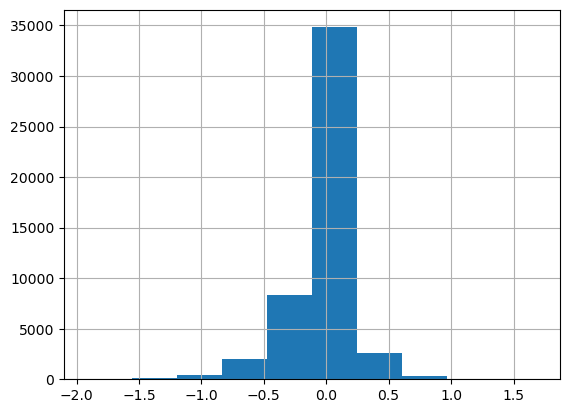

In [15]:
sig_proteins.coef.hist()

In [16]:
sig_proteins.drug.unique().shape

(31,)

In [17]:
sig_proteins[sig_proteins.drug == 'CHEMBL1351'][['protein', 'p_corrected']].sort_values('p_corrected')

protein   p_corrected
54525    LMNA  4.007711e-15
63047   NCEH1  4.007711e-15
53387    PLEC  3.033685e-14
60471   S10AA  1.043151e-13
54567   ESYT2  2.794541e-13
...       ...           ...
62469    NJMU  4.975253e-02
54193    EAF6  4.979886e-02
59945   AL3A2  4.982435e-02
60163    PMVK  4.987330e-02
53609    C1TC  4.998822e-02

[2157 rows x 2 columns]

#### now Viz with sig 

In [34]:
high_std = sig_proteins.groupby('protein').agg({'coef':['mean','std', 'min', 'max']}).sort_values([('coef', 'std')]).dropna().tail(5).index.to_list()
sig_proteins.groupby('protein').agg({'coef':['mean', np.std, 'min', 'max']}).sort_values([('coef', 'std')]).dropna()

coef                              
             mean       std       min       max
protein                                        
AMPB     0.065390  0.000312  0.065170  0.065611
FRMD8   -0.075960  0.000333 -0.076196 -0.075725
IRF9     0.070839  0.000549  0.070451  0.071227
DPP2     0.046485  0.000614  0.046051  0.046920
VASP     0.096282  0.000620  0.095844  0.096720
...           ...       ...       ...       ...
PRP19   -0.222969  0.659848 -0.805269  0.951919
SRSF3   -0.492338  0.668300 -1.176346  0.952994
ELAV1   -0.090565  0.670163 -0.658322  0.981035
SRSF1   -0.310685  0.676812 -0.913781  1.022716
TADBP   -0.620375  0.876655 -1.419230  1.692443

[4692 rows x 4 columns]

In [35]:
mask = [p in high_std for p in sig_proteins.protein]

In [40]:
high_std

['PRP19', 'SRSF3', 'ELAV1', 'SRSF1', 'TADBP']

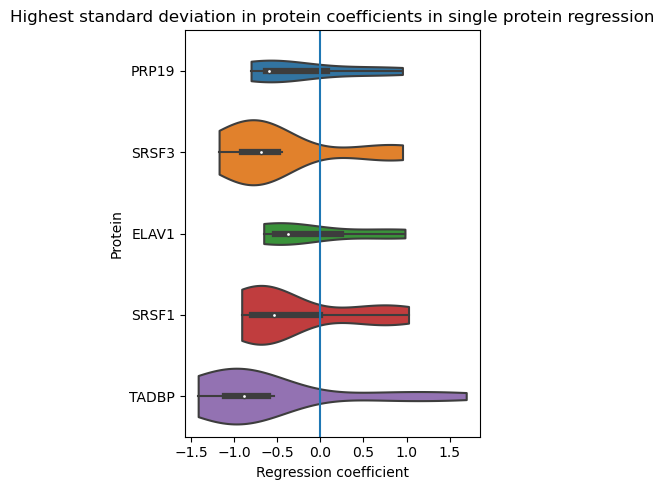

In [42]:
plt.rcParams['figure.figsize'] = (4,5)
plt.rcParams['figure.autolayout'] = True
vio = sns.violinplot(sig_proteins[mask], x='coef', y='protein', cut=0, scale="count", order=high_std)
plt.axvline(0, 0)
vio.set(title="Highest standard deviation in protein coefficients in single protein regression", xlabel="Regression coefficient", ylabel="Protein")
plt.show()

In [29]:
low_std = sig_proteins.groupby('protein').agg({'coef':['mean','std', 'min', 'max']}).sort_values([('coef', 'std')]).dropna().head(5).index.to_list()

In [44]:
mask = [p in low_std for p in sig_proteins.protein]

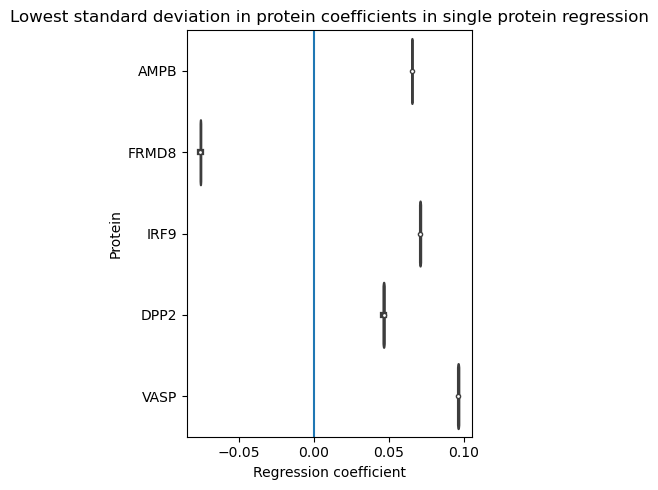

In [45]:
plt.rcParams['figure.figsize'] = (4,5)
plt.rcParams['figure.autolayout'] = True
vio = sns.violinplot(sig_proteins[mask], x='coef', y='protein', cut=0, scale="count", order=low_std)
plt.axvline(0, 0)
vio.set(title="Lowest standard deviation in protein coefficients in single protein regression", xlabel="Regression coefficient", ylabel="Protein")
plt.show()

#### Play around with se

In [9]:
sig_proteins.sort_values(['std err'])

coef_id      coef  std err         z         P>|z|    [0.025    0.975]  \
55051   Paihcj  0.020964    0.004  4.769489  2.207676e-06  0.012335  0.029592   
58679   Phidig  0.026944    0.005  5.064093  5.134696e-07  0.016499  0.037388   
321601  Paihcj  0.031442    0.005  5.823053  8.434556e-09  0.020843  0.042042   
56395   QiNFJf  0.035721    0.005  6.553090  1.028938e-10  0.025020  0.046421   
268291  Paihcj  0.025741    0.005  5.612890  2.764734e-08  0.016739  0.034744   
...        ...       ...      ...       ...           ...       ...       ...   
288745  Pdfgfi -1.135730    0.325 -3.491712  5.071408e-04 -1.774235 -0.497225   
290919  Pdaihg -1.076609    0.326 -3.299152  1.014118e-03 -1.717203 -0.436014   
292615  Pejhjc -1.175943    0.334 -3.521977  4.534353e-04 -1.831376 -0.520511   
160423  Ohffdd -1.023613    0.343 -2.988612  2.890450e-03 -1.695953 -0.351273   
294807  Pgcdbi -1.558422    0.343 -4.544429  6.388960e-06 -2.231605 -0.885238   

        converged  pseudo_r2  train_MSE            MSE  train_pearsonR  \
55051         775   0.028587   0.733677    3483.548533        0.169077   
58679         775   0.032111   0.731016     140.973410        0.179195   
321601        784   0.041559   1.118167    7025.227221        0.203859   
56395         775   0.052630   0.715518      16.376171        0.229412   
268291        783   0.038775   0.805644    4264.424099        0.196913   
...           ...        ...        ...            ...             ...   
288745        776   0.015508   8.468178    2165.821584        0.124530   
290919        776   0.013868   8.482287     950.285549        0.117760   
292615        776   0.015773   8.465893    2867.382054        0.125592   
160423        782   0.011321   5.852921   40475.829065        0.106402   
294807        776   0.025989   8.378027  489574.264397        0.161210   

        pearsonR         drug  n_train  n_test protein   p_corrected  
55051   0.135391   CHEMBL1351      775      48  P08729  1.902245e-05  
58679   0.082079   CHEMBL1351      775      48  P78386  5.672667e-06  
321601  0.201759     CHEMBL98      784      46  P08729  4.957396e-08  
56395   0.052970   CHEMBL1351      775      48  Q8NFJ5  4.723355e-09  
268291  0.277120  CHEMBL64925      783      44  P08729  3.345957e-06  
...          ...          ...      ...     ...     ...           ...  
288745 -0.207126    CHEMBL888      776      46  P35658  2.681753e-03  
290919 -0.036334    CHEMBL888      776      46  P30876  4.595896e-03  
292615 -0.107580    CHEMBL888      776      46  P49792  2.446346e-03  
160423 -0.228931  CHEMBL34259      782      47  O75533  1.253391e-02  
294807 -0.047420    CHEMBL888      776      46  P62318  8.768354e-05  

[60525 rows x 18 columns]

In [43]:
top100 = []

for d in drug_list:
    top100.append(sig_proteins[sig_proteins.drug == d].sort_values(['p_corrected']).head(500))

In [40]:
data = pd.read_csv('data/pc_protein.csv')
y = pd.read_csv('data/pc_drug_response.csv')

In [31]:
d = 'CHEMBL109480'
alpha = 0.05

xy = data.merge(y[y.CHEMBL==d], left_on='Cell_Line', right_on='cell_line_name')
xy = xy.fillna(0).rename(columns={'ln_IC50':'label'}).drop(columns=['cell_line_name','CHEMBL'])
xy.columns = [''.join([chr(int(y)+97) if y.isnumeric() else y for y in x.replace('_','').replace('.','')]) for x in xy.columns]

In [32]:
formular = "label ~ "
formular = formular + " + ".join(top100[0].coef_id.to_list())

In [33]:
ols = smf.ols(formular, data=xy)
results = ols.fit(maxiter=100)

In [34]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  label   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     2.350
Date:                Wed, 27 Sep 2023   Prob (F-statistic):           9.95e-15
Time:                        09:50:46   Log-Likelihood:                -924.40
No. Observations:                 779   AIC:                             2851.
Df Residuals:                     278   BIC:                             5184.
Df Model:                         500                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.9950      6.385     -0.626      0.532     -16.564       8.573
Pbfffj        -0.2253      0.035     -6.392      0.000      -0.295      -0.156
QjBPUg        -0.0541      0.110     -0.493      0.623      -0.270       0.162
QjPcKf        -0.0374      0.069     -0.544      0.587      -0.173       0.098
Qbchfg        -0.1041      0.102     -1.017      0.310      -0.306       0.097
Qbebje         0.1006      0.085      1.181      0.238      -0.067       0.268
Qbfbej        -0.0803      0.129     -0.624      0.533      -0.333       0.173
Paeaid        -0.0867      0.056     -1.556      0.121      -0.196       0.023
QgSZWb         0.0260      0.091      0.286      0.775      -0.153       0.206
QjgFQg        -0.0427      0.072     -0.596      0.552      -0.184       0.098
Pdbjej        -0.1041      0.058     -1.809      0.071      -0.217       0.009
QjUHad        -0.0187      0.140     -0.134      0.894      -0.295       0.257
Pdaidi         0.0146      0.050      0.291      0.771      -0.084       0.113
Qjjhbj         0.0095      0.118      0.080      0.936      -0.223       0.242
Ojffhb         0.0732      0.075      0.975      0.330      -0.075       0.221
QiTBdg         0.0404      0.078      0.516      0.606      -0.114       0.195
Pajjdg         0.0352      0.030      1.160      0.247      -0.025       0.095
Qjjedj         0.1287      0.089      1.454      0.147      -0.046       0.303
QjYgKb        -0.0732      0.138     -0.532      0.595      -0.344       0.198
QigVYe         0.0585      0.062      0.950      0.343      -0.063       0.180
Paibjf         0.1543      0.169      0.911      0.363      -0.179       0.487
Pbgjij         0.1418      0.091      1.558      0.120      -0.037       0.321
Obfcea         0.1202      0.060      2.003      0.046       0.002       0.238
Pbhjdb        -0.0006      0.053     -0.012      0.991      -0.105       0.103
Pbhchf         0.0381      0.071      0.533      0.594      -0.103       0.179
Pacfef         0.1228      0.142      0.866      0.387      -0.156       0.402
QigYRf         0.0921      0.106      0.869      0.386      -0.117       0.301
QjHccd         0.1345      0.116      1.163      0.246      -0.093       0.362
Pgajad         0.2066      0.091      2.263      0.024       0.027       0.386
Pcjhgc         0.0848      0.070      1.218      0.224      -0.052       0.222
Pbagdg         0.1654      0.093      1.782      0.076      -0.017       0.348
Ogacic        -0.0790      0.062     -1.272      0.204      -0.201       0.043
Pidjbg         0.2861      0.172      1.667      0.097      -0.052       0.624
QhLajj         0.1699      0.139      1.219      0.224      -0.104       0.444
Pahdff        -0.1201      0.103     -1.166      0.245      -0.323       0.083
Obffdd        -0.0212      0.093     -0.227      0.820      -0.205       0.162
Qb

In [25]:
data.set_index("Cell_Line", inplace=True)
data

P37108    Q96JP5    Q9Y4H2    P36578    Q6SPF0    O76031  Q8WUQ7  \
Cell_Line                                                                       
TE-12      6.828022  4.143455  2.237808  7.628785  3.198109  4.609018     NaN   
TMK-1      7.014256  4.199872  2.440552  8.124585       NaN  4.768811     NaN   
STS-0421   5.285911  3.357894       NaN  7.972680       NaN  4.520923     NaN   
PL4        5.707857       NaN       NaN  6.225738       NaN  4.495795     NaN   
PCI-4B     6.739649  4.501989       NaN  7.473637       NaN  4.830533     NaN   
...             ...       ...       ...       ...       ...       ...     ...   
451Lu      6.455100  3.817545       NaN  7.551549  3.048080  4.739157     NaN   
MMAc-SF    6.726384       NaN       NaN  7.807513       NaN  5.185211     NaN   
MC-IXC     7.023447  3.128792  3.073864  7.786520  3.246267  4.078294     NaN   
CGTH-W-1   6.316308  4.869332       NaN  7.624330  3.926891  4.472120     NaN   
YMB-1-E    6.765316  3.757772       NaN  7.241326  3.054766  4.740301     NaN   

             A6NIH7    Q9BTD8    Q9P258  ...    Q9NRY2    Q9UHN1    Q9GZQ3  \
Cell_Line                                ...                                 
TE-12      2.470590  3.695348  5.707904  ...       NaN  2.802152       NaN   
TMK-1           NaN       NaN  5.522833  ...  1.086323       NaN       NaN   
STS-0421        NaN  2.730884  4.294287  ...       NaN       NaN       NaN   
PL4             NaN  2.879809       NaN  ...       NaN  3.737752       NaN   
PCI-4B          NaN  3.098548  4.168048  ...       NaN       NaN       NaN   
...             ...       ...       ...  ...       ...       ...       ...   
451Lu           NaN  3.442976  4.988906  ...       NaN       NaN       NaN   
MMAc-SF         NaN  1.521300  4.151795  ...       NaN       NaN       NaN   
MC-IXC     2.584012  3.093444  6.804660  ...       NaN       NaN       NaN   
CGTH-W-1        NaN  3.484641  5.439826  ...       NaN       NaN       NaN   
YMB-1-E         NaN  2.562678  4.247670  ...  1.411235       NaN  2.718422   

             Q8IUR0   O15484  Q9HBF4  Q96RT7  Q8IVH4   Q86SZ2    Q5TA45  
Cell_Line                                                                
TE-12      2.328577      NaN     NaN     NaN     NaN  3.13888  3.196077  
TMK-1      3.337898      NaN     NaN     NaN     NaN      NaN       NaN  
STS-0421        NaN      NaN     NaN     NaN     NaN      NaN  2.790234  
PL4             NaN      NaN     NaN     NaN     NaN      NaN       NaN  
PCI-4B     3.036585      NaN     NaN     NaN     NaN      NaN  1.254513  
...             ...      ...     ...     ...     ...      ...       ...  
451Lu           NaN  3.82058     NaN     NaN     NaN      NaN  2.968384  
MMAc-SF         NaN      NaN     NaN     NaN     NaN      NaN  2.532057  
MC-IXC          NaN      NaN     NaN     NaN     NaN      NaN  2.159391  
CGTH-W-1        NaN      NaN     NaN     NaN     NaN      NaN       NaN  
YMB-1-E         NaN      NaN     NaN     NaN     NaN      NaN  2.463809  

[784 rows x 5331 columns]

In [26]:
t = 0.5
n = data.shape[0] 
# count missing over full data set?
na_count = data.isna().sum(axis=0)
mask = na_count.iloc[:].apply(lambda x: x > t * n)  # ture for all proteins, that have more nan than the threshold t
data = data.drop(columns=na_count.index[mask])

In [28]:
data

P37108    Q96JP5    P36578    Q6SPF0    O76031    Q9BTD8  \
Cell_Line                                                               
TE-12      6.828022  4.143455  7.628785  3.198109  4.609018  3.695348   
TMK-1      7.014256  4.199872  8.124585       NaN  4.768811       NaN   
STS-0421   5.285911  3.357894  7.972680       NaN  4.520923  2.730884   
PL4        5.707857       NaN  6.225738       NaN  4.495795  2.879809   
PCI-4B     6.739649  4.501989  7.473637       NaN  4.830533  3.098548   
...             ...       ...       ...       ...       ...       ...   
451Lu      6.455100  3.817545  7.551549  3.048080  4.739157  3.442976   
MMAc-SF    6.726384       NaN  7.807513       NaN  5.185211  1.521300   
MC-IXC     7.023447  3.128792  7.786520  3.246267  4.078294  3.093444   
CGTH-W-1   6.316308  4.869332  7.624330  3.926891  4.472120  3.484641   
YMB-1-E    6.765316  3.757772  7.241326  3.054766  4.740301  2.562678   

             Q9P258    Q8TCS8    Q96L91    P52701  ...    O00488    P62877  \
Cell_Line                                          ...                       
TE-12      5.707904  5.591560  2.345347  4.782101  ...       NaN  3.852484   
TMK-1      5.522833  5.453060  1.685853  3.651875  ...  2.801678  3.885525   
STS-0421   4.294287  5.426244  2.686038  4.180040  ...       NaN  4.072270   
PL4             NaN  6.292383       NaN  1.775135  ...       NaN  2.385021   
PCI-4B     4.168048  6.020463  1.885720  3.783715  ...  3.872942  3.869057   
...             ...       ...       ...       ...  ...       ...       ...   
451Lu      4.988906  6.111898  1.720494  4.297574  ...       NaN  3.274402   
MMAc-SF    4.151795  5.798821  0.343532  3.272655  ...  3.442443  4.051402   
MC-IXC     6.804660  5.670891       NaN  5.174908  ...  2.633580  4.039030   
CGTH-W-1   5.439826  5.089134       NaN  4.127934  ...  4.794887  3.801180   
YMB-1-E    4.247670  5.469529       NaN  3.784471  ...       NaN  4.024586   

             Q9NX14    Q9Y3E0    P09651    P01111    P12074    Q8WY22  \
Cell_Line                                                               
TE-12      6.135780  1.709889  9.084405  4.426812  3.039617  5.769395   
TMK-1           NaN       NaN  9.014724       NaN       NaN       NaN   
STS-0421   7.176259       NaN  8.812034       NaN  2.077865       NaN   
PL4             NaN       NaN  7.810233  2.913824  3.885762  4.255781   
PCI-4B     7.124569  2.667927  9.772554  3.817272  2.902222  5.592997   
...             ...       ...       ...       ...       ...       ...   
451Lu      7.465402  3.082709  9.259143       NaN  3.048828       NaN   
MMAc-SF    6.824922       NaN  8.545535       NaN  2.691164  4.970476   
MC-IXC     7.253855       NaN  9.160841  4.013476       NaN       NaN   
CGTH-W-1   6.595114  1.584110  9.250869  4.701823  2.163399       NaN   
YMB-1-E         NaN       NaN  7.787795       NaN  2.298027       NaN   

             Q5HYI8    Q8N131  
Cell_Line                      
TE-12      4.297804  5.295486  
TMK-1      3.856578  4.699897  
STS-0421   3.962057  4.302191  
PL4             NaN  6.024478  
PCI-4B     3.962814  7.147750  
...             ...       ...  
451Lu      3.944555  5.896421  
MMAc-SF    3.276126  6.922382  
MC-IXC     3.244866       NaN  
CGTH-W-1   4.526977  5.869905  
YMB-1-E    5.249165  4.201864  

[784 rows x 3334 columns]

In [29]:
corr = data.fillna(0).corr(method='pearson')

In [30]:
import scipy.cluster.hierarchy as spc

corr_v = corr.values

pdist = spc.distance.pdist(corr_v)
linkage = spc.linkage(pdist, method='complete')
group = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')

In [31]:
labels_order = np.argsort(group)

# Build a new dataframe with the sorted columns
for idx, i in enumerate(data.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(data[i])
    else:
        df_to_append = pd.DataFrame(data[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

In [32]:
corr = clustered.fillna(0).corr(method='pearson')

<Axes: >

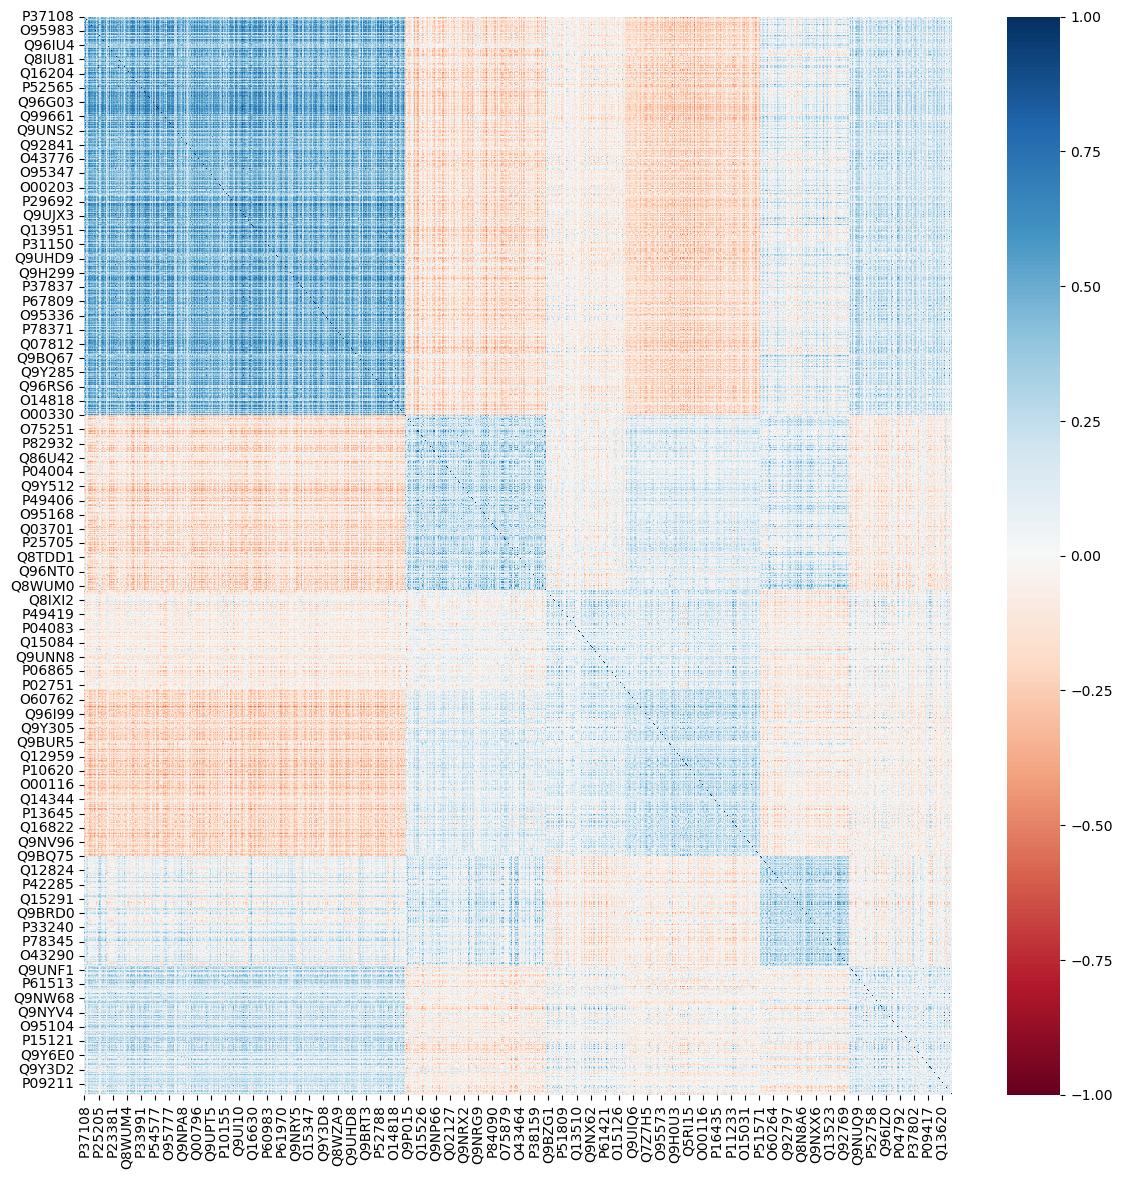

In [33]:
fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(corr,
            vmin=-1,
            cmap='RdBu')

<Axes: >

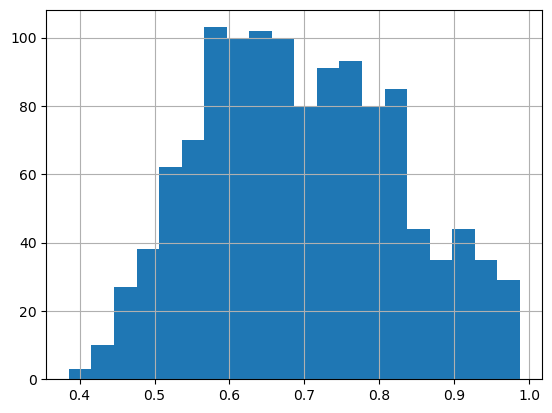

In [40]:
corr.loc[group[labels_order] == 1, group[labels_order] == 1].replace(1.0, 0.0).max().hist(bins=20)

#### save results and further analysis

In [23]:
sig_proteins.to_csv("tmp/sig_protein_results.tsv", sep='\t', index=False)

In [16]:
drug_df = pd.read_csv('data/pc_drug_response.csv', usecols=['CHEMBL','putative_target', 'putative_gene_target', 'target_pathway']).drop_duplicates(ignore_index=True)
drug_df = drug_df.set_index('CHEMBL')
# drug_df = drug_df[drug_df.target_pathway == "EGFR signaling"]

In [17]:
drug_df.shape

(31, 3)

In [18]:
drug_df.putative_gene_target = drug_df.putative_gene_target.astype('string')
# drug_df.dropna(inplace=True)
drug_df.fillna('None', inplace=True)

In [24]:
drug_df.shape

(31, 3)

In [20]:
top10_proteins = []
drug_targets = pd.DataFrame(columns=['target_gene', 'sig', 'top100', 'top10', 'in_data'])  # drug will be the index
for d in drug_df.index.to_list():
    prot = sig_proteins[sig_proteins.drug==d].copy()
    prot.sort_values(['p_corrected', 'train_pearsonR'], axis=0, inplace=True, ascending=[True, False])
    df_top100 = prot.head(100)
    df_top10 = df_top100.head(10).copy()
    df_top10['pathway'] = drug_df.loc[d, 'target_pathway']
    top10_proteins.append(df_top10.head(3))  #changed!!!!
    #print(d)
    
    sig = [x.split('(')[0] in prot.protein.to_list() for x in drug_df.loc[d, 'putative_gene_target'].split(';')]
    top100 = [x.split('(')[0] in df_top100.protein.to_list() for x in drug_df.loc[d, 'putative_gene_target'].split(';')]
    top10 = [x.split('(')[0] in df_top10.protein.to_list() for x in drug_df.loc[d, 'putative_gene_target'].split(';')]
    in_list = [x.split('(')[0] in list(protein_list) for x in drug_df.loc[d, 'putative_gene_target'].split(';')]
    drug_targets.loc[d] = [drug_df.loc[d, 'putative_gene_target'], sig, top100, top10, in_list]

In [21]:
sum(drug_targets.top10.sum()), sum(drug_targets.top100.sum()), sum(drug_targets.sig.sum()), sum(drug_targets.in_data.sum())  

(0, 0, 8, 22)

In [22]:
# for these genes we have the proteins in the data, for the rest of the drugs, the data might not be helpful 
# 
drug_targets[[True in x for x in drug_targets.in_data]]

target_gene  \
CHEMBL939                                                   EGFR   
CHEMBL98       HDAC1;HDAC10;HDAC2;HDAC3;HDAC4;HDAC5;HDAC6;HDA...   
CHEMBL1201182                                               MTOR   
CHEMBL288441                                        ABL1;SRC;TEC   
CHEMBL1173655                                         EGFR;ERBB2   
CHEMBL202721                                         AURKA;AURKB   
CHEMBL1879463                   PIK3CA;PIK3CB;PIK3CD;PIK3CG;MTOR   
CHEMBL601719                                        ALK;MET;ROS1   
CHEMBL413                                                   MTOR   
CHEMBL1336                           FLT1;KIT;PDGFRA;PDGFRB;RAF1   
CHEMBL553                                                   EGFR   
CHEMBL417                                                  TOP2A   
CHEMBL3137336                                     AKT1;AKT2;AKT3   
CHEMBL554                                             EGFR;ERBB2   

                                                             sig  \
CHEMBL939                                                 [True]   
CHEMBL98       [False, False, True, False, True, False, False...   
CHEMBL1201182                                            [False]   
CHEMBL288441                               [False, False, False]   
CHEMBL1173655                                      [False, True]   
CHEMBL202721                                       [False, True]   
CHEMBL1879463                [False, False, False, False, False]   
CHEMBL601719                                [False, True, False]   
CHEMBL413                                                [False]   
CHEMBL1336                   [False, False, False, False, False]   
CHEMBL553                                                 [True]   
CHEMBL417                                                [False]   
CHEMBL3137336                              [False, False, False]   
CHEMBL554                                          [False, True]   

                                                          top100  \
CHEMBL939                                                [False]   
CHEMBL98       [False, False, False, False, False, False, Fal...   
CHEMBL1201182                                            [False]   
CHEMBL288441                               [False, False, False]   
CHEMBL1173655                                     [False, False]   
CHEMBL202721                                      [False, False]   
CHEMBL1879463                [False, False, False, False, False]   
CHEMBL601719                               [False, False, False]   
CHEMBL413                                                [False]   
CHEMBL1336                   [False, False, False, False, False]   
CHEMBL553                                                [False]   
CHEMBL417                                                [False]   
CHEMBL3137336                              [False, False, False]   
CHEMBL554                                         [False, False]   

                                                           top10  \
CHEMBL939                                                [False]   
CHEMBL98       [False, False, False, False, False, False, Fal...   
CHEMBL1201182                                            [False]   
CHEMBL288441                               [False, False, False]   
CHEMBL1173655                                     [False, False]   
CHEMBL202721                                      [False, False]   
CHEMBL1879463                [False, False, False, False, False]   
CHEMBL601719                               [False, False, False]   
CHEMBL413                                                [False]   
CHEMBL1336                   [False, False, False, False, False]   
CHEMBL553                                                [False]   
CHEMBL417                                                [False]   
CHEMBL3137336                              [False, False, False]   
CHEMBL554                             

In [52]:
data.shape

(784, 5332)

In [30]:
sig_proteins[(sig_proteins.protein == "EGFR")]

coef_id      coef  std err          z         P>|z|    [0.025  \
1275    Paafdd -0.064535    0.016  -3.935203  9.248493e-05 -0.096740   
33261   Paafdd  0.069552    0.019   3.599641  3.437853e-04  0.031609   
43923   Paafdd  0.085237    0.010   8.866437  7.933695e-18  0.066358   
54585   Paafdd  0.055944    0.008   7.218211  1.543833e-12  0.040724   
86571   Paafdd -0.038984    0.012  -3.324653  9.368136e-04 -0.062010   
97233   Paafdd  0.062440    0.014   4.315355  1.850825e-05  0.034026   
107895  Paafdd  0.062384    0.016   4.014302  6.682460e-05  0.031866   
129219  Paafdd -0.062266    0.013  -4.680830  3.506911e-06 -0.088389   
139881  Paafdd  0.083343    0.017   5.034577  6.293752e-07  0.050834   
182529  Paafdd  0.086971    0.014   6.425043  2.608996e-10  0.060389   
193191  Paafdd  0.056733    0.015   3.801170  1.581863e-04  0.027423   
203853  Paafdd  0.069878    0.020   3.545750  4.209145e-04  0.031177   
214515  Paafdd -0.069441    0.014  -4.961236  9.051553e-07 -0.096927   
225177  Paafdd  0.080393    0.019   4.182731  3.296582e-05  0.042648   
246501  Paafdd  0.061940    0.013   4.614495  4.780374e-06  0.035581   
257163  Paafdd  0.034291    0.013   2.583691  1.000078e-02  0.008228   
278487  Paafdd  0.039032    0.011   3.611003  3.293618e-04  0.017805   
310473  Paafdd -0.042549    0.013  -3.290797  1.054979e-03 -0.067939   
321135  Paafdd  0.097315    0.009  10.512654  6.393812e-24  0.079137   

          0.975]  converged  pseudo_r2  train_MSE       MSE  train_pearsonR  \
1275   -0.032330        625   0.024254   3.150270  3.439564        0.155737   
33261   0.107495        630   0.020216   4.429748  5.376824        0.142182   
43923   0.104115        624   0.112207   1.083303  1.562856        0.334973   
54585   0.071164        623   0.077407   0.697331  0.734138        0.278220   
86571  -0.015957        630   0.017296   1.631369  2.023163        0.131516   
97233   0.090854        630   0.028799   2.484135  2.976998        0.169704   
107895  0.092901        630   0.025018   2.865494  3.064502        0.158172   
129219 -0.036143        626   0.033921   2.084628  1.951099        0.184178   
139881  0.115852        619   0.039460   3.185294  3.460019        0.198645   
182529  0.113553        629   0.061772   2.173524  2.445341        0.248540   
193191  0.086043        624   0.022702   2.611135  2.425951        0.150673   
203853  0.108579        624   0.019812   4.552597  4.717571        0.140756   
214515 -0.041954        624   0.038066   2.296397  2.567300        0.195105   
225177  0.118137        621   0.027487   4.298301  4.363081        0.165792   
246501  0.088300        629   0.032846   2.137301  2.475862        0.181233   
257163  0.060355        627   0.010568   2.077589  1.865161        0.102800   
278487  0.060258        630   0.020341   1.386307  1.671320        0.142622   
310473 -0.017158        630   0.016952   1.983578  1.871400        0.130199   
321135  0.115493        630   0.149646   1.016746  1.063642        0.386841   

        pearsonR           drug  n_train  n_test protein   p_corrected  
1275    0.151870   CHEMBL109480      625     156    EGFR  2.650068e-03  
33261   0.048696  CHEMBL1231160      630     156    EGFR  2.066220e-03  
43923   0.274499     CHEMBL1336      624     155    EGFR  2.628532e-15  
54585   0.196271     CHEMBL1351      623     154    EGFR  4.307293e-10  
86571   0.214643  CHEMBL1879463      630     156    EGFR  6.508583e-03  
97233   0.233151   CHEMBL191334      630     156    EGFR  2.991227e-04  
107895  0.154300   CHEMBL202721      630     156    EGFR  7.039474e-04  
129219  0.225155   CHEMBL288441      626     156    EGFR  2.999238e-04  
139881  0.079698  CHEMBL3137336      619     154    EGFR  8.778127e-05  
182529  0.153477   CHEMBL414804      629     155    EGFR  1.162209e-08  
193191  0.021074      CHEMBL417      624     155    EGFR  1.225944e-03  
203853 -0.014479   CHEMBL428647      624     155    EGFR  4.307466e-03  
214515  0.201776      CHEMBL553     

In [29]:
top10_proteins = pd.concat(top10_proteins)

In [35]:
top10_proteins[['drug', 'protein']].sort_values('drug').tail(53)

drug protein
25291  CHEMBL3137336     UFO
25251  CHEMBL3137336    ITA3
26963   CHEMBL325041   K1C19
27251   CHEMBL325041   CEAM6
27235   CHEMBL325041    ODO2
29085    CHEMBL34259    RL12
28589    CHEMBL34259   RPAC1
29009    CHEMBL34259    NUCL
30987      CHEMBL413    RL12
31687      CHEMBL413    ENAH
31201      CHEMBL413    RL31
32859   CHEMBL414804    ITA3
33335   CHEMBL414804    PLEC
32589   CHEMBL414804    LMNA
34791      CHEMBL417    RL12
34689      CHEMBL417    NCPR
35005      CHEMBL417    RL31
36393   CHEMBL428647    LMNA
37267   CHEMBL428647   NCEH1
37531   CHEMBL428647   DAZP1
38979      CHEMBL553   TRI29
39127      CHEMBL553   FA83B
38293      CHEMBL553   K2C6A
41071   CHEMBL553025   NCEH1
40497   CHEMBL553025    RL12
40197   CHEMBL553025    LMNA
42089      CHEMBL554    CYTA
42931      CHEMBL554   FA83B
41863      CHEMBL554    LAD1
44001   CHEMBL601719    LMNA
44271   CHEMBL601719    ITA3
44875   CHEMBL601719   NCEH1
46623   CHEMBL603469   GANAB
46091   CHEMBL603469    MUC1
46203   CHEMBL603469    RL12
48105    CHEMBL64925    RL12
48297    CHEMBL64925   RAB10
48373    CHEMBL64925    ODO1
50581       CHEMBL83   NCEH1
49977       CHEMBL83    ITA3
50311       CHEMBL83    AHNK
51807      CHEMBL888    NCPR
51909      CHEMBL888    RL12
52123      CHEMBL888    RL31
54385       CHEMBL92   NCEH1
53811       CHEMBL92    RL12
53881       CHEMBL92   BUD31
55411      CHEMBL939   K2C6A
55403      CHEMBL939    CYTA
56245      CHEMBL939   FA83B
58061       CHEMBL98    PLEC
57585       CHEMBL98    ITA3
58189       CHEMBL98   NCEH1

In [31]:
target_drugs = drug_targets.index[[True in x for x in drug_targets.sig]].to_list()

In [32]:
exp_model = pd.read_csv('snakemake/results/exp_results/combined_performances.tsv', sep='\t')
exp_model

train_pseudo_r2  train_adj_r2  train_MSE        MSE  train_pearsonR  \
0           0.466764      0.258602   1.749452   4.195700        0.683201   
1           0.997058     -0.147397   0.009652  13.519379        0.998528   
2           0.997058     -0.147397   0.009652  13.519379        0.998528   
3           0.466764      0.258602   1.749452   4.195700        0.683201   
4           0.997058     -0.147397   0.009652  27.255330        0.998528   
..               ...           ...        ...        ...             ...   
181         0.999824      0.930902   0.000205   7.922288        0.999912   
182         0.999824      0.930902   0.000205   7.922288        0.999912   
183         0.747309      0.303992   0.294102   2.761052        0.864471   
184         0.999824      0.930902   0.000205   8.889753        0.999912   
185         0.999824      0.930902   0.000205   8.889753        0.999912   

     pearsonR          drug  order  n_prot  n_obs  n_feat  n_syn  \
0    0.142107  CHEMBL109480      1     219    781     219      0   
1    0.300070  CHEMBL109480      2     219    781    2729   2510   
2    0.300070  CHEMBL109480      4     219    781    2729   2510   
3    0.142107  CHEMBL109480      1     219    781     219      0   
4    0.083933  CHEMBL109480      2     219    781    1318   1099   
..        ...           ...    ...     ...    ...     ...    ...   
181  0.031039      CHEMBL98      2     500    786    3819   3319   
182  0.031039      CHEMBL98      4     500    786    3819   3319   
183  0.073963      CHEMBL98      1     500    786     500      0   
184  0.069192      CHEMBL98      2     500    786    1466    966   
185  0.069192      CHEMBL98      4     500    786    1466    966   

             config     fit  
0    a: 0.05 f: 0.1  normal  
1    a: 0.05 f: 0.1  normal  
2    a: 0.05 f: 0.1  normal  
3    a: 0.05 f: 0.3  normal  
4    a: 0.05 f: 0.3  normal  
..              ...     ...  
181  a: 0.05 f: 0.1  normal  
182  a: 0.05 f: 0.1  normal  
183  a: 0.05 f: 0.3  normal  
184  a: 0.05 f: 0.3  normal  
185  a: 0.05 f: 0.3  normal  

[186 rows x 14 columns]

In [24]:
exp_model.dropna()

train_pseudo_r2  train_adj_r2  train_MSE        MSE  train_pearsonR  \
6           0.869551      0.472276   0.421570   8.014571        0.932497   
7           0.986623      0.666641   0.043231  50.044551        0.993289   
8           0.988474      0.687801   0.037248  63.984193        0.994220   
9           0.869551      0.472276   0.421570   8.014571        0.932497   
10          0.887676      0.465818   0.362997   9.751478        0.942166   
11          0.887676      0.465818   0.362997   9.751478        0.942166   
24          0.817069      0.684584   0.893028   3.595124        0.903919   
25          0.828491      0.700947   0.837267   3.739522        0.910215   
26          0.828491      0.700947   0.837267   3.739522        0.910215   
27          0.817069      0.684584   0.893028   3.595124        0.903919   
28          0.818056      0.684529   0.888208   3.631596        0.904465   
29          0.818056      0.684529   0.888208   3.631596        0.904465   
72          0.957720      0.560992   0.158190  21.538498        0.978632   
75          0.957720      0.560992   0.158190  21.538498        0.978632   
144         0.847312      0.360554   0.329948   6.063853        0.920495   
145         0.869837      0.334246   0.281274   7.372754        0.932650   
146         0.869837      0.334246   0.281274   7.372754        0.932650   
147         0.847312      0.360554   0.329948   6.063853        0.920495   
148         0.852253      0.359761   0.319271   6.389937        0.923175   
149         0.852253      0.359761   0.319271   6.389937        0.923175   
162         0.784606      0.430811   0.270734   2.807158        0.885780   
163         0.797581      0.460506   0.254425   2.856285        0.893074   
164         0.797581      0.460506   0.254425   2.856285        0.893074   
177         0.347311      0.216773   1.671645   3.323018        0.589331   
178         0.347311      0.216773   1.671645   3.323018        0.589331   
179         0.347380      0.215333   1.671468   3.325230        0.589390   
180         0.128865      0.107195   2.231122   3.045099        0.358978   
181         0.128865      0.107195   2.231122   3.045099        0.358978   
182         0.130345      0.107231   2.227332   3.061845        0.361033   

     pearsonR           drug  order  n_prot  n_obs  n_feat  n_syn  \
6    0.342894   CHEMBL109480      1     469    624     469      0   
7    0.000877   CHEMBL109480      2     469    624     598    129   
8   -0.038193   CHEMBL109480      4     469    624     600    134   
9    0.342894   CHEMBL109480      1     469    624     469      0   
10   0.268005   CHEMBL109480      2     469    624     492     23   
11   0.268005   CHEMBL109480      4     469    624     492     23   
24   0.608699  CHEMBL1201182      1     259    620     259      0   
25   0.595033  CHEMBL1201182      2     259    620     263      4   
26   0.595033  CHEMBL1201182      4     259    620     263      4   
27   0.608699  CHEMBL1201182      1     259    620     259      0   
28   0.604915  CHEMBL1201182      2     259    620     261      2   
29   0.604915  CHEMBL1201182      4     259    620     261      2   
72   0.256737  CHEMBL1614701      1     562    624     562      0   
75   0.256737  CHEMBL1614701      1     562    624     562      0   
144  0.266692   CHEMBL288441      1     475    625     475      0   
145  0.236809   CHEMBL288441      2     475    625     502     27   
146  0.236809   CHEMBL288441      4     475    625     502     27   
147  0.266692   CHEMBL288441      1     475    625     475      0   
148  0.276810   CHEMBL288441      2     475    625     480      5   
149  0.276810   CHEMBL288441      4     475    625     480      5   
162  0.161900   CHEMBL325041      1     386    622     386      0   
163  0.159227   CHEMBL325041      2     386    622     388      2   
164  0.159227   CHEMBL325041      4     386    622     388      2   
177  0.246012      CHEMBL413      1     103    619     103      0   

In [33]:
exp_model[[d in target_drugs for d in exp_model.drug]]#.dropna()

train_pseudo_r2  train_adj_r2  train_MSE         MSE  train_pearsonR  \
6           0.618099      0.267012   1.027422    5.318093        0.786193   
7           0.993464     -1.565266   0.017583   41.012825        0.996727   
8           0.993464     -1.565266   0.017583   41.012825        0.996727   
9           0.618099      0.267012   1.027422    5.318093        0.786193   
10          0.983003      0.297763   0.045726  447.810594        0.991465   
11          0.983003      0.297763   0.045726  447.810594        0.991465   
120         0.610614      0.305178   0.950490    2.374093        0.781418   
121         0.981111     -6.347929   0.046109   11.243904        0.990510   
122         0.981111     -6.347929   0.046109   11.243904        0.990510   
123         0.610614      0.305178   0.950490    2.374093        0.781418   
124         0.981111     -6.347929   0.046109   92.054732        0.990510   
125         0.981111     -6.347929   0.046109   92.054732        0.990510   
174         0.636246      0.298410   0.726367    3.081635        0.797650   
175         0.985219     -4.801400   0.029515   18.756835        0.992582   
176         0.985219     -4.801400   0.029515   18.756835        0.992582   
177         0.636246      0.298410   0.726367    3.081635        0.797650   
178         0.948547      0.014862   0.102745  148.862582        0.973934   
179         0.948547      0.014862   0.102745  148.862582        0.973934   
180         0.747309      0.303992   0.294102    2.761052        0.864471   
181         0.999824      0.930902   0.000205    7.922288        0.999912   
182         0.999824      0.930902   0.000205    7.922288        0.999912   
183         0.747309      0.303992   0.294102    2.761052        0.864471   
184         0.999824      0.930902   0.000205    8.889753        0.999912   
185         0.999824      0.930902   0.000205    8.889753        0.999912   

     pearsonR           drug  order  n_prot  n_obs  n_feat  n_syn  \
6    0.550064  CHEMBL1173655      1     376    786     376      0   
7    0.236086  CHEMBL1173655      2     376    786    1346    970   
8    0.236086  CHEMBL1173655      4     376    786    1346    970   
9    0.550064  CHEMBL1173655      1     376    786     376      0   
10  -0.064952  CHEMBL1173655      2     376    786     766    390   
11  -0.064952  CHEMBL1173655      4     376    786     766    390   
120  0.411296      CHEMBL553      1     342    779     342      0   
121  0.446407      CHEMBL553      2     342    779    1695   1353   
122  0.446407      CHEMBL553      4     342    779    1695   1353   
123  0.411296      CHEMBL553      1     342    779     342      0   
124  0.363355      CHEMBL553      2     342    779     914    572   
125  0.363355      CHEMBL553      4     342    779     914    572   
174  0.339919      CHEMBL939      1     378    786     378      0   
175  0.219929      CHEMBL939      2     378    786    1421   1043   
176  0.219929      CHEMBL939      4     378    786    1421   1043   
177  0.339919      CHEMBL939      1     378    786     378      0   
178  0.126069      CHEMBL939      2     378    786     744    366   
179  0.126069      CHEMBL939      4     378    786     744    366   
180  0.073963       CHEMBL98      1     500    786     500      0   
181  0.031039       CHEMBL98      2     500    786    3819   3319   
182  0.031039       CHEMBL98      4     500    786    3819   3319   
183  0.073963       CHEMBL98      1     500    786     500      0   
184  0.069192       CHEMBL98      2     500    786    1466    966   
185  0.069192       CHEMBL98      4     500    786    1466    966   

             config     fit  
6    a: 0.05 f: 0.1  normal  
7    a: 0.05 f: 0.1  normal  
8    a: 0.05 f: 0.1  normal  
9    a: 0.05 f: 0.3  normal  
10   a: 0.05 f: 0.3  normal  
11   a: 0.05 f: 0.3  normal  
120  a: 0.05 f: 0.1  normal  
121  a: 0.05 f: 0.1  normal  
122  a: 0.05 f: 0.1  normal  
123  a: 0.05 f: 0.3  normal  
124  a: 0.05 f: 0.3  no

### id mapping, not necessary

In [135]:
sig_proteins['gene_name'] = 'default'
prot_list = set(sig_proteins.protein)
print(len(prot_list))

request = IdMappingClient.submit(
    source="UniProtKB_AC-ID", dest="Gene_Name", ids=prot_list
)

6129


In [136]:
while True:
    status = request.get_status()
    if status in {"FINISHED", "ERROR"}:
        break
    else:
        time.sleep(5)

In [137]:
request.get_status()

'FINISHED'

In [27]:
result = list(request.each_result())
len(result)

5953

In [138]:
for dic in request.each_result():
    sig_proteins.gene_name[sig_proteins.protein == dic['from']] = dic['to']

C:\Users\wen068\AppData\Local\Temp\ipykernel_18904\762012980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_proteins.gene_name[sig_proteins.protein == dic['from']] = dic['to']


In [140]:
sig_proteins[(sig_proteins.gene_name == "default")]

coef_id      coef  std err         z         P>|z|  \
818        QiWZAjIRGQHUMAN  0.273057    0.065  4.203594  3.519891e-05   
1124      QhZgZhHUWEbHUMAN  0.291382    0.091  3.209735  1.475084e-03   
1553       QjNZMbMYOFHUMAN -0.164918    0.050 -3.298543  1.174881e-03   
11522     QjHgZeRANBdHUMAN  0.323395    0.074  4.351587  1.879035e-05   
14675     QfZPRdCDchgHUMAN -0.418209    0.126 -3.327129  1.173125e-03   
...                    ...       ...      ...       ...           ...   
11455911   QiWZAaLZICHUMAN -0.177464    0.068 -2.617711  9.156598e-03   
11455929   QjNZJgCOQdHUMAN  0.449290    0.088  5.090979  7.715504e-07   
11456040   QhZcWjRMcbHUMAN  0.455721    0.077  5.915377  6.167834e-09   
11456133   QjGZZjUBAfHUMAN -0.229093    0.093 -2.473721  1.385498e-02   
11456343  QjBTZcDHRSeHUMAN  0.329688    0.060  5.467116  7.705748e-08   

            [0.025    0.975]  converged  pseudo_r2  train_MSE       MSE  \
818       0.145199  0.400916        287   0.058381   1.003351  1.606445   
1124      0.112722  0.470042        297   0.033745   1.031341  1.582439   
1553     -0.263586 -0.066251        179   0.057911   1.221716  2.836745   
11522     0.177123  0.469668        290   0.061695   1.008635  1.656596   
14675    -0.667144 -0.169273        119   0.086436   1.244719  2.727242   
...            ...       ...        ...        ...        ...       ...   
11455911 -0.310703 -0.044225        443   0.015301   1.238748  0.979832   
11455929  0.275349  0.623231        219   0.106695   0.924437  1.076305   
11456040  0.304357  0.607086        499   0.065775   1.113477  0.966779   
11456133 -0.411250 -0.046937        345   0.017528   1.183198  0.926353   
11456343  0.211166  0.448209        439   0.064018   1.108624  1.077362   

          train_pearsonR  pearsonR  drug  n_train  n_test protein  \
818             0.241622  0.057681     1      287      73  Q8WZ7A   
1124            0.183698  0.217207     1      297      78  Q7Z76Z   
1553            0.240648 -0.022685     1      179      42  Q9NZ7M   
11522           0.248384 -0.032890     1      290      76  Q9H6Z7   
14675           0.293999 -0.022769     1      119      32  Q5Z7PR   
...                  ...       ...   ...      ...     ...     ...   
11455911        0.123696  0.211177  2510      443     114  Q8WZ7A   
11455929        0.326642 -0.161923  2510      219      50  Q9NZ7J   
11456040        0.256466  0.320048  2510      499     129  Q7Z72W   
11456133        0.132393  0.296643  2510      345      99  Q9GZ7Z   
11456343        0.253018  0.126277  2510      439     115  Q9BTZ7   

           p_corrected gene_name  
818       6.977245e-03   default  
1124      4.668474e-02   default  
1553      4.259737e-02   default  
11522     5.176093e-03   default  
14675     4.259737e-02   default  
...                ...       ...  
11455911  2.722736e-02   default  
11455929  6.837412e-06   default  
11456040  1.044062e-07   default  
11456133  3.838383e-02   default  
11456343  9.278674e-07   default  

[26251 rows x 19 columns]

### basic analysis with concentration

In [73]:
df_conc = df[df.coef_id == 'maxscreeningconc']
sig_conc = df_conc[df_conc['P>|z|'] < 0.05]
conc_counts = sig_conc.drug.value_counts()
# In half the drugs, the dosis has a significant influence on the result in a single protein regression

In [66]:
df_proteins = df[df.coef_id.str.contains('HUMAN')]
df_proteins

coef_id      coef  std err         z     P>|z|    [0.025  \
2         PdhbaiSRPbeHUMAN  0.344876    0.103  3.350153  0.000913  0.142280   
5         QjgJPfZFPjbHUMAN  0.293598    0.130  2.263659  0.024617  0.037916   
8          QjYeHcIRScHUMAN -0.008152    0.200 -0.040702  0.967673 -0.409041   
11          PdgfhiRLeHUMAN -0.106366    0.124 -0.860458  0.390235 -0.349647   
14        QgSPFaSAMDbHUMAN  0.108384    0.073  1.491971  0.136967 -0.034690   
...                    ...       ...      ...       ...       ...       ...   
11457372  QfTAefINTbbHUMAN -0.232405    0.098 -2.371406  0.018447 -0.425383   
11457375  QhZdBbNEGRbHUMAN  0.041528    0.096  0.431608  0.667477 -0.150687   
11457378   OgaggjMOTcHUMAN  0.526110    0.340  1.547260  0.131950 -0.167379   
11457381  QbdfhbLAPMfHUMAN -0.104523    0.395 -0.264885  0.793809 -0.927642   
11457384  QjgJMcZNegcHUMAN  0.482589    0.203  2.374347  0.020796  0.076026   

            0.975]  converged  pseudo_r2  train_MSE       MSE  train_pearsonR  \
2         0.547473        297   0.036651   1.028239  1.867878        0.191446   
5         0.549281        212   0.023820   1.024769  2.191084        0.154336   
8         0.392738         60   0.000029   1.511382  1.972468        0.005344   
11        0.136914        297   0.002504   1.064687  1.881234        0.050035   
14        0.251458        252   0.008825   0.974873  1.740995        0.093943   
...            ...        ...        ...        ...       ...             ...   
11457372 -0.039428        263   0.021092   1.094999  1.048937        0.145230   
11457375  0.233744         66   0.002902   0.779036  1.743302        0.053873   
11457378  1.219599         33   0.071690   1.286882  1.339712        0.267750   
11457381  0.718595         22   0.003496   1.843370  1.255639        0.059126   
11457384  0.889153         62   0.085889   0.805035  0.866990        0.293068   

          pearsonR  drug  n_train  n_test              protein  
2         0.050281     1      297      79   P37108.SRP14_HUMAN  
5        -0.084071     1      212      63  Q96JP5.-7FP91_HUMAN  
8        -0.213663     1       60      19    Q9Y4H2.IRS2_HUMAN  
11       -0.108920     1      297      79     P36578.RL4_HUMAN  
14        0.140308     1      252      71   Q6SPF0.SAMD1_HUMAN  
...            ...   ...      ...     ...                  ...  
11457372 -0.062422  2510      263      63   Q5TA45.INT11_HUMAN  
11457375  0.161875  2510       66      12  Q7-73B.1NEGR1_HUMAN  
11457378 -0.047780  2510       33      10    O60669.MOT2_HUMAN  
11457381 -0.005309  2510       22      11   Q13571.LAPM5_HUMAN  
11457384 -0.176673  2510       62      16  Q96JM2.-7N462_HUMAN  

[3818695 rows x 17 columns]

In [74]:
sig_proteins = df_proteins[df_proteins['P>|z|']<0.05]
prot_counts = sig_proteins.drug.value_counts()

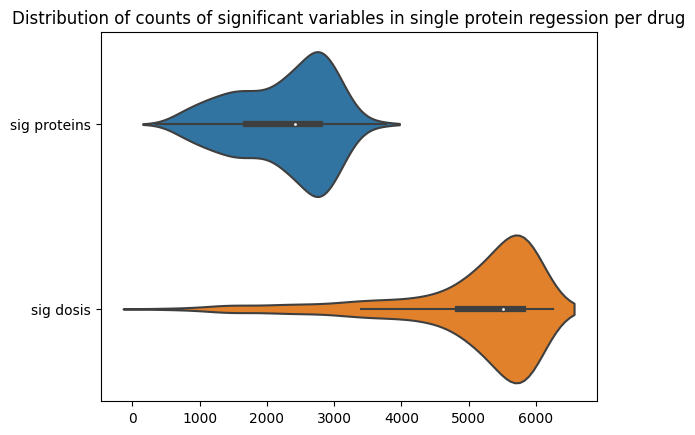

In [78]:
plot = sns.violinplot([prot_counts, conc_counts], cut=True, orient='h' )
plot.set(title='Distribution of counts of significant variables in single protein regession per drug')
plot.set_yticks(range(2))
plot.set_yticklabels(['sig proteins', 'sig dosis'])
plt.show()

In [70]:
sig_proteins[sig_proteins.drug == 1]

coef_id      coef  std err         z     P>|z|    [0.025  \
2      PdhbaiSRPbeHUMAN  0.344876    0.103  3.350153  0.000913  0.142280   
5      QjgJPfZFPjbHUMAN  0.293598    0.130  2.263659  0.024617  0.037916   
17      OhgadbCLPXHUMAN -0.272634    0.136 -2.011889  0.045141 -0.539325   
26      QjPcfiRCCcHUMAN  0.154205    0.060  2.555974  0.011092  0.035469   
32      QgiDKhMSLbHUMAN  0.278303    0.124  2.238358  0.028858  0.029683   
...                 ...       ...      ...       ...       ...       ...   
15923  QjNYRjKBRScHUMAN  0.344464    0.102  3.369227  0.001345  0.139812   
15965  QjNPfaSHCAFHUMAN  0.211151    0.099  2.126712  0.036035  0.014045   
16016  AgNCjiCCiiBHUMAN  0.904205    0.236  3.827147  0.000771  0.417617   
16019    QjUBKjUXTHUMAN  0.341796    0.118  2.893053  0.005081  0.106166   
16049   QgPbgbRMfeHUMAN -0.363989    0.141 -2.573256  0.011313 -0.644100   

         0.975]  converged  pseudo_r2  train_MSE       MSE  train_pearsonR  \
2      0.547473        297   0.036651   1.028239  1.867878        0.191446   
5      0.549281        212   0.023820   1.024769  2.191084        0.154336   
17    -0.005942        297   0.013535   1.052912  1.926358        0.116341   
26     0.272941        296   0.021738   1.046705  1.802610        0.147438   
32     0.526924         63   0.075901   0.732984  5.028165        0.275501   
...         ...        ...        ...        ...       ...             ...   
15923  0.549117         60   0.163683   0.290699  0.640816        0.404578   
15965  0.408256         97   0.045446   0.625095  1.036760        0.213180   
16016  1.390793         27   0.369436   0.827432  1.458424        0.607813   
16019  0.577426         72   0.106798   0.629218  0.780104        0.326800   
16049 -0.083878        120   0.053134   0.985729  2.451217        0.230508   

       pearsonR  drug  n_train  n_test              protein  
2      0.050281     1      297      79   P37108.SRP14_HUMAN  
5     -0.084071     1      212      63  Q96JP5.-7FP91_HUMAN  
17    -0.131889     1      297      79    O76031.CLPX_HUMAN  
26     0.224306     1      296      79    Q9P258.RCC2_HUMAN  
32    -0.296581     1       63      13    Q68DK7.MSL1_HUMAN  
...         ...   ...      ...     ...                  ...  
15923  0.396037     1       60       9   Q9NYR9.KBRS2_HUMAN  
15965  0.134718     1       97      22   Q9NP50.SHCAF_HUMAN  
16016  0.150571     1       27      10   A6NC98.CC88B_HUMAN  
16019  0.048992     1       72      25     Q9UBK9.UXT_HUMAN  
16049  0.109897     1      120      30    Q6P161.RM54_HUMAN  

[955 rows x 17 columns]

In [57]:
pearsonR = pd.pivot_table(df, values='pearsonR', index=['drug'], columns=['protein'], aggfunc=np.mean, fill_value=0)

<Axes: ylabel='Frequency'>

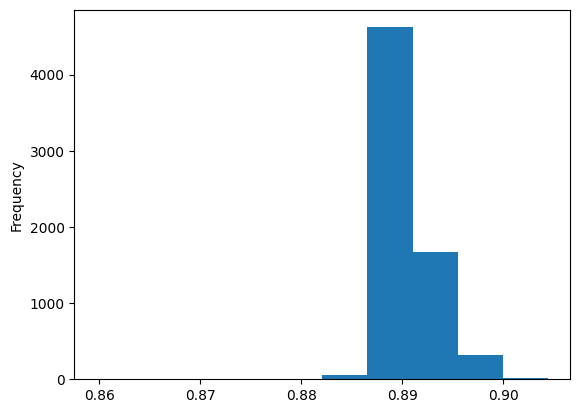

In [59]:
pearsonR.max(axis=0).plot.hist()

In [37]:
df[(df.drug==1)]

coef_id      coef  std err          z          P>|z|  \
0             Intercept  0.045401    0.139   0.327307   7.436675e-01   
1      maxscreeningconc  0.090802    0.277   0.327307   7.436675e-01   
2      PdhbaiSRPbeHUMAN  0.344876    0.103   3.350153   9.127479e-04   
3             Intercept  0.312031    0.094   3.323116   1.050116e-03   
4      maxscreeningconc  0.624062    0.188   3.323116   1.050116e-03   
...                 ...       ...      ...        ...            ...   
16095         Intercept  0.613268    0.234   2.623360   1.588114e-02   
16096  maxscreeningconc  1.226535    0.468   2.623360   1.588114e-02   
16097  QbdfhbLAPMfHUMAN -0.241349    0.330  -0.731199   4.727384e-01   
16098         Intercept  0.508417    0.012  42.333167  1.339536e-127   
16099  maxscreeningconc  1.016834    0.024  42.333167  1.339536e-127   

         [0.025    0.975]  converged  pseudo_r2  train_MSE       MSE  \
0     -0.227587  0.318389        297   0.036651   1.028239  1.867878   
1     -0.455174  0.636779        297   0.036651   1.028239  1.867878   
2      0.142280  0.547473        297   0.036651   1.028239  1.867878   
3      0.126929  0.497132        212   0.023820   1.024769  2.191084   
4      0.253858  0.994265        212   0.023820   1.024769  2.191084   
...         ...       ...        ...        ...        ...       ...   
16095  0.127113  1.099423         23   0.024828   1.286461  1.369504   
16096  0.254225  2.198845         23   0.024828   1.286461  1.369504   
16097 -0.927772  0.445075         23   0.024828   1.286461  1.369504   
16098  0.484782  0.532053        297   0.000000   1.067359  1.869774   
16099  0.969563  1.064105        297   0.000000   1.067359  1.869774   

       train_pearsonR  pearsonR  drug  n_train  n_test              protein  
0            0.191446  0.050281     1      297      79   P37108.SRP14_HUMAN  
1            0.191446  0.050281     1      297      79   P37108.SRP14_HUMAN  
2            0.191446  0.050281     1      297      79   P37108.SRP14_HUMAN  
3            0.154336 -0.084071     1      212      63  Q96JP5.-7FP91_HUMAN  
4            0.154336 -0.084071     1      212      63  Q96JP5.-7FP91_HUMAN  
...               ...       ...   ...      ...     ...                  ...  
16095        0.157567 -0.240216     1       23      11   Q13571.LAPM5_HUMAN  
16096        0.157567 -0.240216     1       23      11   Q13571.LAPM5_HUMAN  
16097        0.157567 -0.240216     1       23      11   Q13571.LAPM5_HUMAN  
16098             NaN       NaN     1      297      79               DOSIS.  
16099             NaN       NaN     1      297      79               DOSIS.  

[16100 rows x 17 columns]

In [18]:
performance = df[['pearsonR', 'MSE', 'drug', 'protein']].drop_duplicates(ignore_index=True)

In [19]:
performance['group'] = performance.protein == 'DOSIS.'

In [30]:
performance[~performance.group].dropna()

pearsonR       MSE  drug              protein  group
0        0.050281  1.867878     1   P37108.SRP14_HUMAN  False
1       -0.084071  2.191084     1  Q96JP5.-7FP91_HUMAN  False
2       -0.213663  1.972468     1    Q9Y4H2.IRS2_HUMAN  False
3       -0.108920  1.881234     1     P36578.RL4_HUMAN  False
4        0.140308  1.740995     1   Q6SPF0.SAMD1_HUMAN  False
...           ...       ...   ...                  ...    ...
3819340 -0.062422  1.048937  2510   Q5TA45.INT11_HUMAN  False
3819341  0.161875  1.743302  2510  Q7-73B.1NEGR1_HUMAN  False
3819342 -0.047780  1.339712  2510    O60669.MOT2_HUMAN  False
3819343 -0.005309  1.255639  2510   Q13571.LAPM5_HUMAN  False
3819344 -0.176673  0.866990  2510  Q96JM2.-7N462_HUMAN  False

[3818695 rows x 5 columns]

In [36]:
baseline = performance[performance.group]
baseline

pearsonR       MSE  drug protein  group
5366          NaN  1.869774     1  DOSIS.   True
10588         NaN  4.714342     3  DOSIS.   True
15965         NaN  3.085074     5  DOSIS.   True
21354         NaN  0.599534     6  DOSIS.   True
26711         NaN  2.227019     9  DOSIS.   True
...           ...       ...   ...     ...    ...
3795992       NaN  1.143818  2504  DOSIS.   True
3801816       NaN  5.318066  2505  DOSIS.   True
3807657       NaN  7.409905  2508  DOSIS.   True
3813504       NaN  3.046614  2509  DOSIS.   True
3819345       NaN  1.147556  2510  DOSIS.   True

[651 rows x 5 columns]

In [54]:
drugs_with_2 = baseline.dropna().drug.unique()
drugs_with_2
mask = [d in drugs_with_2 for d in performance.drug]
with_baseline = performance[mask]

In [59]:
with_baseline.dropna()

pearsonR       MSE  drug              protein  group
1290189  0.229819  2.385504  1005   P37108.SRP14_HUMAN  False
1290190  0.242908  2.197911  1005  Q96JP5.-7FP91_HUMAN  False
1290191  0.110185  2.802077  1005    Q9Y4H2.IRS2_HUMAN  False
1290192  0.317409  2.252200  1005     P36578.RL4_HUMAN  False
1290193  0.240209  2.384350  1005   Q6SPF0.SAMD1_HUMAN  False
...           ...       ...   ...                  ...    ...
2402815  0.317518  5.200910  1529  Q7-73B.1NEGR1_HUMAN  False
2402816  0.474059  4.488082  1529    O60669.MOT2_HUMAN  False
2402817  0.173176  1.308127  1529   Q13571.LAPM5_HUMAN  False
2402818  0.258435  2.489758  1529  Q96JM2.-7N462_HUMAN  False
2402819  0.180812  3.932128  1529               DOSIS.   True

[230056 rows x 5 columns]

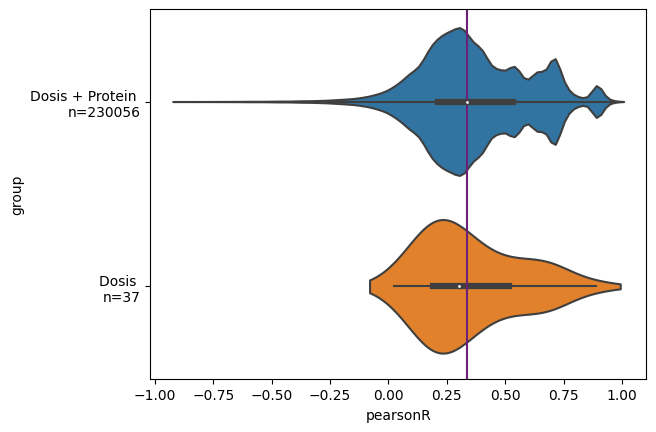

In [63]:
plot = sns.violinplot(with_baseline, x='pearsonR', y='group', orient='h', cut=True)
plt.axvline(with_baseline.pearsonR.median(), 0, c="#6D2077")
plot.set_yticks(range(2))
plot.set_yticklabels([f'Dosis + Protein \nn={with_baseline.shape[0]}', 'Dosis \nn=37'])
plt.show()

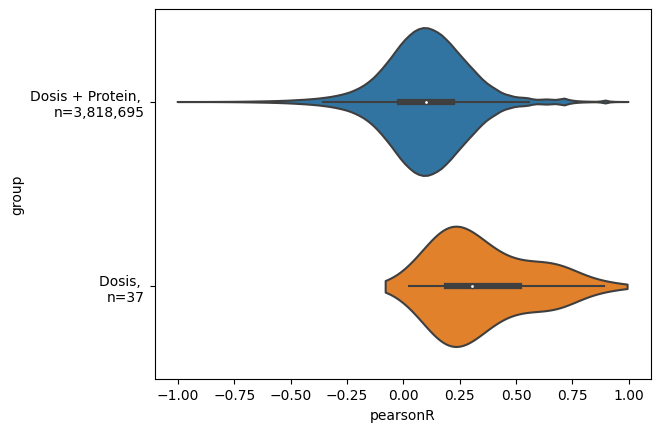

In [35]:
plot = sns.violinplot(performance, x='pearsonR', y='group', orient='h', cut=True)
plot.set_yticks(range(2))
plot.set_yticklabels(['Dosis + Protein, \nn=3,818,695', 'Dosis, \nn=37'])
plt.show()

In [7]:
y_input = 'data/DrugResponse_PANCANCER_GDSC1_GDSC2_20200602.csv'
y = pd.read_csv(y_input)[['drug_id','cell_line_name','ln_IC50', 'max_screening_conc']]

C:\Users\wen068\AppData\Local\Temp\ipykernel_15244\1923757283.py:2: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  y = pd.read_csv(y_input)[['drug_id','cell_line_name','ln_IC50', 'max_screening_conc']]


<Axes: xlabel='ln_IC50', ylabel='max_screening_conc'>

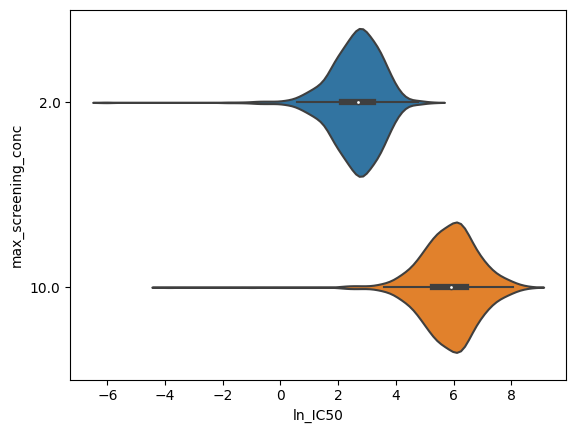

In [11]:
sns.violinplot(y[y.drug_id==1029], x='ln_IC50', y ='max_screening_conc', orient='h')

<Axes: ylabel='Frequency'>

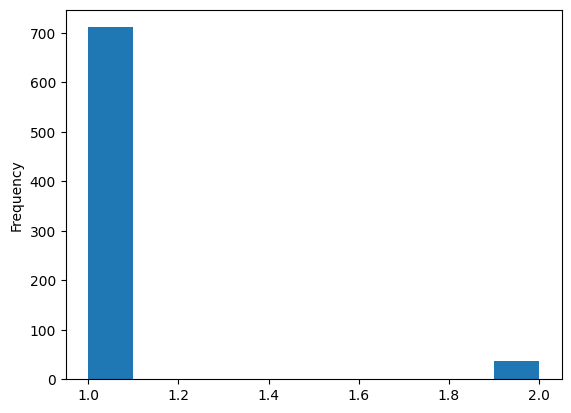

In [51]:
y[['drug_id', 'max_screening_conc']].drop_duplicates().drug_id.value_counts().plot.hist()

### Regression test code

In [2]:
working_dir = 'tmp/'

# File inputs
# x_input = 'data/ProCan-DepMapSanger_protein_matrix_6692_averaged.xlsx'
x_input = 'data/train_protein_matrix.csv'
y_input = 'data/DrugResponse_PANCANCER_GDSC1_GDSC2_20200602.csv'

test_input = 'data/test_protein_matrix.csv'


In [3]:
x = pd.read_csv(x_input)
c = [a.replace('.','').replace('_','') for a in x.columns]
x.columns = c

x_test = pd.read_csv(test_input)
x_test.columns = c

y = pd.read_csv(y_input)[['drug_id','cell_line_name','ln_IC50', 'max_screening_conc']]

C:\Users\wen068\AppData\Local\Temp\ipykernel_10264\2547150521.py:8: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  y = pd.read_csv(y_input)[['drug_id','cell_line_name','ln_IC50', 'max_screening_conc']]


In [4]:
drug_list = np.unique(y.drug_id)
protein_list = c[1:]

In [5]:
def results_fit_to_df(results, ols, y, test_data):
    coeffs = results.params.tolist()
    pvals = results.pvalues.tolist()
    pseudo_r2 = results.rsquared
    # adj_r2 = results.rsquared_adj
    tvals = results.tvalues.tolist()
    cint_low = results.conf_int()[0].tolist()
    cint_high = results.conf_int()[1].tolist()

    pred_y = results.predict()
    train_pear_R = pearsonr(pred_y, y).statistic
    train_mse = np.square(y - pred_y).mean()

    if len(test_data.ln_IC50) < 8:
        test_pear_R = None
        test_mse = None
    else:    
        test_y = test_data.ln_IC50.to_list()
        pred_y = results.predict(test_data)
        test_pear_R = pearsonr(pred_y, test_y).statistic   # want 20 entries for this
        test_mse = np.square(test_y - pred_y).mean()

    
    try:
        results = results.summary()
    except:
        #ValueError: resids must contain at least 2 elements
        r = pd.DataFrame([1,2,3]) #dirty...
        r['z']='nan'
        return r
    converged = results.tables[0].data[5][1].strip()
    results = results.tables[1].data
    results = pd.DataFrame(results[1:], columns=['coef_id', 'coef', 'std err', 'z', 'P>|z|', '[0.025', '0.975]'])
    results['P>|z|'] = pvals
    results['z'] = tvals 
    results['coef'] = coeffs
    results['converged'] = converged
    results['pseudo_r2'] = pseudo_r2
    # results['adj_r2'] = adj_r2
    results["train_MSE"] = train_mse
    results["MSE"] = test_mse
    results['[0.025'] = cint_low
    results['0.975]'] = cint_high
    results["train_pearsonR"] = train_pear_R
    results["pearsonR"] = test_pear_R
    return results

In [23]:
regression_results = []
for d in drug_list[:1]:
    print(f'currently looking at drug {d}')
    c = 0
    xy = x.merge(y[y["drug_id"]==d], left_on='CellLine', right_on='cell_line_name')
    test_xy = x_test.merge(y[y["drug_id"] == d], left_on='CellLine', right_on='cell_line_name')
    for p in protein_list:

        
        data = xy[["ln_IC50", "max_screening_conc", p]].dropna()
        test_data = test_xy[["ln_IC50", "max_screening_conc", p]].dropna()

        # print(f'For drug {d} and {p} there are {len(data[p])} and {len(test_data[p])} cell lines')

        if len(test_data[p]) < 8:
            # print(f'Not enough test cell lines for protein {p} and drug {d}, n = {len(test_data[p])}')
            c += 1
            continue

        formula = "ln_IC50 ~ max_screening_conc + " + p
        ols = smf.ols(formula,data=data)
        results = ols.fit(disp=False, maxiter=1000)
        results = results_fit_to_df(results, ols, data["ln_IC50"].to_list(), test_data)
        results["drug"] = d
        results["n_train"] = len(data[p])
        results["n_test"] = len(test_data[p])
        regression_results.append(results.loc[[2]])
        del data, test_data   
    print(f'For {c} proteins we did not have enough data')
    del xy, test_xy
regression_results = pd.concat(regression_results)

currently looking at drug 1


C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1965: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1965: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1965: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\wen068\AppData\Roaming\Python\Python311\site-packages\statsmodels\regression\linear_model.py:1965: RuntimeWarning: divide by

For 1326 proteins we did not have enough data


In [22]:
1.5*949/60

23.725

In [18]:
regression_results

coef_id      coef    std err         z     P>|z|    [0.025  \
2   P37108SRP14HUMAN  0.344876      0.103  3.350153  0.000913  0.142280   
2   Q96JP5ZFP91HUMAN  0.293598      0.130  2.263659  0.024617  0.037916   
2    Q9Y4H2IRS2HUMAN -0.008152      0.200 -0.040702  0.967673 -0.409041   
2     P36578RL4HUMAN -0.106366      0.124 -0.860458  0.390235 -0.349647   
2   Q6SPF0SAMD1HUMAN  0.108384      0.073  1.491971  0.136967 -0.034690   
..               ...       ...        ...       ...       ...       ...   
2    Q96RT7GCP6HUMAN -0.009340      0.174 -0.053654  0.957555 -0.364363   
2   Q86SZ2TPC6BHUMAN  0.329737      0.213  1.547722  0.126331 -0.095391   
2   Q5EBL4RIPL1HUMAN  0.013412      0.143  0.093868  0.925589 -0.273580   
2   Q5TA45INT11HUMAN -0.119480      0.120 -0.997674  0.319944 -0.355992   
2   Q13571LAPM5HUMAN -0.241349      0.330 -0.731199  0.472738 -0.927772   

      0.975] converged  pseudo_r2  train_MSE       MSE  train_pearsonR  \
2   0.547473       297   0.036651   1.028239  1.867878        0.191446   
2   0.549281       212   0.023820   1.024769  2.191084        0.154336   
2   0.392738        60   0.000029   1.511382  1.972468        0.005344   
2   0.136914       297   0.002504   1.064687  1.881234        0.050035   
2   0.251458       252   0.008825   0.974873  1.740995        0.093943   
..       ...       ...        ...        ...       ...             ...   
2   0.345683        33   0.000093   0.604705  0.390081        0.009636   
2   0.754866        70   0.034028   1.068815  3.837595        0.184468   
2   0.300404        52   0.000176   0.664233  0.957161        0.013274   
2   0.117031       162   0.006183   1.185055  1.522771        0.078629   
2   0.445075        23   0.024828   1.286461  1.369504        0.157567   

    pearsonR  drug  n_train  n_test  
2   0.050281     1      297      79  
2  -0.084071     1      212      63  
2  -0.213663     1       60      19  
2  -0.108920     1      297      79  
2   0.140308     1      252      71  
..       ...   ...      ...     ...  
2  -0.155726     1       33      11  
2   0.018681     1       70      17  
2  -0.229536     1       52      17  
2   0.100663     1      162      37  
2  -0.240216     1       23      11  

[5366 rows x 16 columns]

In [45]:
regression_results.to_csv("protein_regression.csv", index=False)

pd.pivot_table(regression_results, values='pearsonR', index=['drug'], columns=['coef_id'], aggfunc=np.sum, fill_value=0).to_csv("protein_regression_pearsonR.csv")

coef_id      coef    std err         z     P>|z|    [0.025  \
2  P37108SRP14HUMAN  0.344876      0.103  3.350153  0.000913  0.142280   
2  Q96JP5ZFP91HUMAN  0.083934      0.035  2.367290  0.018564  0.014156   
2   Q9Y4H2IRS2HUMAN -0.048480      0.055 -0.883640  0.377612 -0.156455   
2    P36578RL4HUMAN -0.106366      0.124 -0.860458  0.390235 -0.349647   
2  Q6SPF0SAMD1HUMAN  0.083535      0.040  2.105337  0.036107  0.005448   
2   O76031CLPXHUMAN -0.272634      0.136 -2.011889  0.045141 -0.539325   
2  Q8WUQ7CATINHUMAN  0.167690      0.244  0.687954  0.492024 -0.312029   
2  A6NIH7U119BHUMAN  0.064529      0.045  1.427413  0.154519 -0.024440   
2  Q9BTD8RBM42HUMAN  0.057629      0.071  0.807258  0.420168 -0.082866   
2   Q9P258RCC2HUMAN  0.129715      0.057  2.260317  0.024530  0.016773   
2  P37108SRP14HUMAN  0.218291      0.208  1.050435  0.294472 -0.190871   
2  Q96JP5ZFP91HUMAN  0.035078      0.073  0.483103  0.629420 -0.107886   
2   Q9Y4H2IRS2HUMAN  0.305006      0.110  2.761839  0.006148  0.087566   
2    P36578RL4HUMAN -0.226488      0.244 -0.929134  0.353662 -0.706438   
2  Q6SPF0SAMD1HUMAN  0.040110      0.081  0.496618  0.619869 -0.118912   
2   O76031CLPXHUMAN -0.004213      0.271 -0.015565  0.987593 -0.537160   
2  Q8WUQ7CATINHUMAN  0.274099      0.539  0.508515  0.611514 -0.787186   
2  A6NIH7U119BHUMAN  0.166826      0.092  1.815929  0.070507 -0.014055   
2  Q9BTD8RBM42HUMAN -0.082826      0.152 -0.544624  0.586469 -0.382260   
2   Q9P258RCC2HUMAN  0.052983      0.109  0.485573  0.627669 -0.161855   
2  P37108SRP14HUMAN  0.190286      0.165  1.153816  0.249509 -0.134281   
2  Q96JP5ZFP91HUMAN  0.094537      0.056  1.688208  0.092428 -0.015670   
2   Q9Y4H2IRS2HUMAN -0.019039      0.084 -0.225504  0.821744 -0.185194   
2    P36578RL4HUMAN -0.832535      0.189 -4.405879  0.000015 -1.204416   
2  Q6SPF0SAMD1HUMAN  0.025819      0.063  0.409980  0.682118 -0.098119   
2   O76031CLPXHUMAN -0.152810      0.213 -0.715768  0.474701 -0.572969   
2  Q8WUQ7CATINHUMAN  0.068165      0.412  0.165478  0.868681 -0.742523   
2  A6NIH7U119BHUMAN  0.126132      0.072  1.756073  0.080114 -0.015225   
2  Q9BTD8RBM42HUMAN -0.136265      0.110 -1.234361  0.218051 -0.353523   
2   Q9P258RCC2HUMAN -0.271106      0.085 -3.177373  0.001644 -0.439028   

     0.975] converged     pseudo_r2    adj_r2  train_MSE       MSE  \
2  0.547473       297  3.665141e-02  0.033386   1.028239  1.867878   
2  0.153712       297  1.864266e-02  0.015316   1.047461  1.920604   
2  0.059496       297  2.648817e-03 -0.004136   1.064532  1.881244   
2  0.136914       297  2.503509e-03 -0.000878   1.064687  1.881234   
2  0.161623       297  1.480281e-02  0.011463   1.051559  1.857387   
2 -0.005942       297  1.353529e-02  0.010191   1.052912  1.926358   
2  0.647409       297  1.607213e-03 -0.005185   1.065644  1.859011   
2  0.153498       297  6.859431e-03  0.003493   1.060038  1.860427   
2  0.198123       297  2.204167e-03 -0.001178   1.065006  1.871115   
2  0.242657       297  1.702392e-02  0.013692   1.049188  1.812365   
2  0.627452       268  4.131032e-03  0.000387   3.916686  4.841381   
2  0.178043       268  8.766317e-04 -0.002879   3.929485  4.741736   
2  0.522445       268  2.787640e-02  0.024222   3.823297  4.358310   
2  0.253462       268  3.234951e-03 -0.000512   3.920210  4.674171   
2  0.199131       268  9.263178e-04 -0.002830   3.929290  4.752394   
2  0.528734       268  9.107727e-07 -0.003758   3.932929  4.714833   
2  1.335384       268  9.711893e-04 -0.002785   3.929113  4.734822   
2  0.347708       268  1.224518e-02  0.008532   3.884773  4.675456   
2  0.216607       268  1.113852e-03 -0.002641   3.928552  4.727829   
2  0.267821       268  8.856119e-04 -0.002870   3.929450  4.743247   
2  0.514853       297  4.492581e-03  0.001118   2.668946  3.023564   
2  0.204745       297  9.568733e-03  0.006211   2.655337  3.059215   
2  0.147117       297  1.723494e-04 -0.003217   2.680528  3.122536   
2 -0.460655       297  6.173997e-02  

In [38]:
xy = x.merge(y[y["drug_id"]==3], left_on='CellLine', right_on='cell_line_name')
test_xy = x_test.merge(y[y["drug_id"] == 1], left_on='CellLine', right_on='cell_line_name')

data = xy[["ln_IC50", "max_screening_conc", 'P37108SRP14HUMAN']].dropna()
test_data = test_xy[["ln_IC50", "max_screening_conc", 'P37108SRP14HUMAN']].dropna()

# print(f'For drug {d} and {p} there are {len(data[p])} and {len(test_data[p])} cell lines')


formula = "ln_IC50 ~ max_screening_conc"
ols = smf.ols(formula,data=data)
results = ols.fit(disp=False, maxiter=1000)

In [40]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ln_IC50   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 16 Aug 2023   Prob (F-statistic):                nan
Time:                        15:33:58   Log-Likelihood:                -563.77
No. Observations:                 268   AIC:                             1130.
Df Residuals:                     267   BIC:                             1133.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -2.1651      0.120    -18.018      0.000      -2.402      -1.929
max_screening_conc    -0.2165      0.012    -18.018      0.000      -0.240      -0.193
==============================================================================
Omnibus:                       48.714   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.518
Skew:                          -1.098   Prob(JB):                     1.79e-16
Kurtosis:                       4.295   Cond. No.                     2.11e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.09e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [44]:
results.predict(test_data)

0    -2.59817
1    -2.59817
2    -2.59817
3    -2.59817
4    -2.59817
       ...   
74   -2.59817
75   -2.59817
76   -2.59817
77   -2.59817
78   -2.59817
Length: 79, dtype: float64

In [45]:
set(data.max_screening_conc)

{0.1}